# Imports

In [1]:
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

# Code queries

In [46]:
pythonCode = '''def update_currentTask(self, token):
        if self.currentTasks:
            if token in self.currentTasks:
                if self.currentTasks[token]:
                    self.currentTasks[token] = False
                    return True, False, True
                else:
                    return True, True, True
            else:
                return False, False, False
        else:
            self.currentTasks[token] = False
            return False, False, False'''

In [47]:
cSharpCode = '''using System;

namespace HelloWorldApp {
    class Program {
        static void Main(string[] args) {
            Greeter greeter = new Greeter();

            greeter.SayHello("World");
        }
    }

    class Greeter {
        public void SayHello(string name) {
            Console.WriteLine($"Hello, {name}!");
        }
    }
}'''

In [48]:
typescriptCode = '''const App = () => {
  const {user} = useContext(UserContext);

  return (
    <BrowserRouter>
        <NavBar/>
          <Routes>
            <Route path='/' element={<Home/>} />
            <Route path='/flowers' element={<AllProducts/>} />
            <Route path='/login' element={<LoginScreen/>} />
            <Route path='/signup' element={user === null ? <RegisterScreen/> : <Home/>} />
            <Route path='/account' element={user !== null ? <UserSettingsScreen/> : <Home/>} />
            <Route path='/cart' element={<ShoppingCart/>} />
            <Route path='/blogs' element={<BlogsList/>} />
            <Route path='blog/:id' element={<BlogDetails/>} />
            <Route path="/blogs/createBlog" element={user?.role === 1 ? <CreateBlog/> : <Home/>} />
            <Route path='editBlog/:id' element={user?.role === 1 ? <EditBlog/> : <Home/>} />
            <Route path="/orders" element={user?.role === 1 ? <OrdersAdminScreen/> : <Home/>} />
          </Routes>
          <Footer/>
    </BrowserRouter>
  );
}

export default App;
'''

# Code Samples

In [49]:
python_code_samples = [
'''# Python3 program to add two numbers

number1 = input("First number: ")
number2 = input("\nSecond number: ")

# Adding two numbers
# User might also enter float numbers
sum = float(number1) + float(number2)

# Display the sum
# will print value in float
print("The sum of {0} and {1} is {2}" .format(number1, 
											number2, sum))
''',
'''# Python 3 program to find 
# factorial of given number
def factorial(n):
	
	# single line to find factorial
	return 1 if (n==1 or n==0) else n * factorial(n - 1) 

# Driver Code
num = 5
print("Factorial of",num,"is",factorial(num))
''',
'''# Function for nth Fibonacci number

def Fibonacci(n):
	if n<= 0:
		print("Incorrect input")
	# First Fibonacci number is 0
	elif n == 1:
		return 0
	# Second Fibonacci number is 1
	elif n == 2:
		return 1
	else:
		return Fibonacci(n-1)+Fibonacci(n-2)

# Driver Program

print(Fibonacci(10))
''']

In [50]:
cSharp_code_samples = ['''using System;

class Program
{
    static void Main()
    {
        Console.WriteLine("Enter the first number:");
        // Reads the first number from user input, converts it to an integer
        int num1 = Convert.ToInt32(Console.ReadLine());

        Console.WriteLine("Enter the second number:");
        // Reads the second number from user input, converts it to an integer
        int num2 = Convert.ToInt32(Console.ReadLine());

        // Adds the two numbers
        int sum = num1 + num2;

        // Prints the result
        Console.WriteLine("The sum of {0} and {1} is {2}.", num1, num2, sum);

        // Keeps the console window open until a key is pressed
        Console.WriteLine("Press any key to exit.");
        Console.ReadKey();
    }
}
''',
'''using System;

class Program
{
    static void Main()
    {
        Console.Write("Enter a number: ");
        int number = Convert.ToInt32(Console.ReadLine());
        long factorial = Factorial(number);
        Console.WriteLine($"The factorial of {number} is {factorial}.");
    }

    static long Factorial(int n)
    {
        if (n <= 1)
            return 1;
        else
            return n * Factorial(n - 1);
    }
}
''',
'''using System;

class Program
{
    static void Main()
    {
        Console.Write("Enter the Fibonacci sequence number: ");
        int n = Convert.ToInt32(Console.ReadLine());
        long fibonacci = Fibonacci(n);
        Console.WriteLine($"The {n}-th Fibonacci number is {fibonacci}.");
    }

    static long Fibonacci(int n)
    {
        if (n <= 0)
            return 0;
        else if (n == 1)
            return 1;
        else
            return Fibonacci(n - 1) + Fibonacci(n - 2);
    }
}
''']

In [51]:
typescript_code_samples = ['''// Asks the user to input two numbers
let num1: number = parseFloat(prompt("Enter the first number:") || "0");
let num2: number = parseFloat(prompt("Enter the second number:") || "0");

// Adds the two numbers
let sum: number = num1 + num2;

// Shows the result
alert(`The sum of ${num1} and ${num2} is ${sum}.`);
''',
'''function factorial(n: number): number {
    if (n <= 1) return 1;
    else return n * factorial(n - 1);
}

const number: number = parseInt(prompt("Enter a number:") || "0", 10);
const result: number = factorial(number);
alert(`The factorial of ${number} is ${result}.`);
''',
'''function fibonacci(n: number): number {
    if (n <= 0) return 0;
    else if (n === 1) return 1;
    else return fibonacci(n - 1) + fibonacci(n - 2);
}

const n: number = parseInt(prompt("Enter the Fibonacci sequence number:") || "0", 10);
const result: number = fibonacci(n);
alert(`The ${n}-th Fibonacci number is ${result}.`);
''']

In [52]:
all_code_samples = python_code_samples + cSharp_code_samples + typescript_code_samples


# stable-code-3b

## functions

In [71]:
def stable_code_3b_init():
    tokenizer = AutoTokenizer.from_pretrained("stabilityai/stable-code-3b")
    model = AutoModelForCausalLM.from_pretrained("stabilityai/stable-code-3b", torch_dtype="auto")
    return tokenizer, model;

def stable_code_3b_single_input(input, tokenizer, model):
    token = tokenizer(input, return_tensors="pt").to(model.device)
    output = model(input_ids=token['input_ids'], attention_mask=token['attention_mask'], output_hidden_states=True)
    return [torch.mean(output[0][0], dim=0).to(torch.float32).cpu().detach().numpy()]
    
def stable_code_3b_multiple_input(inputs, tokenizer, model):
    stablecode_samples=[]
    a = 1
    for i in inputs:
        stablecode_sample_inputs = tokenizer(i, return_tensors="pt").to(model.device)
        stablecode_sample_output = model(input_ids=stablecode_sample_inputs['input_ids'], attention_mask=stablecode_sample_inputs['attention_mask'], output_hidden_states=True)
        stablecode_samples.append([torch.mean(stablecode_sample_output[0][0], dim=0).to(torch.float32).cpu().detach().numpy()])
        if a%10 == 0:
            print(a)
            !free -h
        a += 1
    return stablecode_samples

## small testing

In [54]:
tokenizer, model = stable_code_3b_init()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
stablecode_samples = stable_code_3b_multiple_input(all_code_samples, tokenizer, model)

In [72]:
python1 = stable_code_3b_single_input(pythonCode, tokenizer, model)
cSharp1 = stable_code_3b_single_input(cSharpCode, tokenizer, model)
typescript1 = stable_code_3b_single_input(typescriptCode, tokenizer, model)

In [73]:
print("Python sample")
for i in stablecode_samples:
    similarity = cosine_similarity(python1, i)
    print(similarity)

Python sample
[[0.977677]]
[[0.9783443]]
[[0.9880212]]
[[0.9813939]]
[[0.9929009]]
[[0.9926641]]
[[0.9809873]]
[[0.98855543]]
[[0.9886776]]


In [74]:
print("C# sample")
for i in stablecode_samples:
    similarity = cosine_similarity(cSharp1, i)
    print(similarity)

C# sample
[[0.9819085]]
[[0.9811089]]
[[0.98840106]]
[[0.9900643]]
[[0.9966748]]
[[0.99572545]]
[[0.98692346]]
[[0.9913117]]
[[0.9904263]]


In [75]:
print("Typescript sample")
for i in stablecode_samples:
    similarity = cosine_similarity(typescript1, i)
    print(similarity)

Typescript sample
[[0.9759061]]
[[0.9753736]]
[[0.983871]]
[[0.98121715]]
[[0.99026227]]
[[0.98978245]]
[[0.98074687]]
[[0.98672587]]
[[0.986588]]


# deepseek-coder-6.7b-instruct

## functions

In [76]:
def deepseek_init():
    tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-6.7b-instruct")
    model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-6.7b-instruct")
    return tokenizer, model
    
def deepseek_multiple_input(inputs, tokenizer, model):
    deepseek_samples=[]
    a = 1
    for i in inputs:
        deepseek_sample_inputs = tokenizer(i, return_tensors="pt").to(model.device)
        deepseek_sample_output = model(input_ids=deepseek_sample_inputs['input_ids'], attention_mask=deepseek_sample_inputs['attention_mask'], output_hidden_states=True)
        deepseek_samples.append([torch.mean(deepseek_sample_output[0][0], dim=0).to(torch.float32).cpu().detach().numpy()])
        if a%10 == 0:
            print(a)
            !free -h
        a += 1
    return deepseek_samples

def deepseek_single_input(input, tokenizer, model):
    token = tokenizer(input, return_tensors="pt").to(model.device)
    output = model(input_ids=token['input_ids'], attention_mask=token['attention_mask'], output_hidden_states=True)
    return [torch.mean(output[0][0], dim=0).to(torch.float32).cpu().detach().numpy()]

## small testing

In [77]:
tokenizer, model = deepseek_init()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [79]:
pythonInputs = tokenizer(pythonCode, return_tensors="pt").to(model.device)
cSharpInputs = tokenizer(cSharpCode, return_tensors="pt").to(model.device)
typescriptInputs = tokenizer(typescriptCode, return_tensors="pt").to(model.device)

python3 = model(input_ids=pythonInputs['input_ids'], attention_mask=pythonInputs['attention_mask'], output_hidden_states=True)
cSharp3 = model(input_ids=cSharpInputs['input_ids'], attention_mask=cSharpInputs['attention_mask'], output_hidden_states=True)
typescript3 = model(input_ids=typescriptInputs['input_ids'], attention_mask=typescriptInputs['attention_mask'], output_hidden_states=True)

In [82]:
deepseek_samples = deepseek_multiple_input(all_code_samples, tokenizer, model)

In [ ]:
print(similarity)

In [83]:
print("Python sample")
for i in deepseek_samples:
    similarity = cosine_similarity([torch.mean(python3[0][0], dim=0).to(torch.float32).cpu().detach().numpy()], i)
    print(similarity)

Python sample
[[0.4679159]]
[[0.01440512]]
[[0.6976739]]
[[0.938334]]
[[0.9463754]]
[[0.948686]]
[[0.96177137]]
[[0.9644305]]
[[0.96100765]]


In [84]:
print("C# sample")
for i in deepseek_samples:
    similarity = cosine_similarity([torch.mean(cSharp3[0][0], dim=0).to(torch.float32).cpu().detach().numpy()], i)
    print(similarity)

C# sample
[[0.5058682]]
[[0.06443264]]
[[0.72039366]]
[[0.94116116]]
[[0.97443324]]
[[0.9668354]]
[[0.94886863]]
[[0.95777345]]
[[0.9516603]]


In [85]:
print("Typescript sample")
for i in deepseek_samples:
    similarity = cosine_similarity([torch.mean(typescript3[0][0], dim=0).to(torch.float32).cpu().detach().numpy()], i)
    print(similarity)

Typescript sample
[[0.4647433]]
[[0.016731]]
[[0.71249175]]
[[0.90739036]]
[[0.9411051]]
[[0.9457228]]
[[0.9509637]]
[[0.96025884]]
[[0.9558414]]


# OpenCodeInterpreter

## functions

In [88]:
def openCode_init():
    tokenizer = AutoTokenizer.from_pretrained("m-a-p/OpenCodeInterpreter-DS-6.7B")
    model = AutoModelForCausalLM.from_pretrained("m-a-p/OpenCodeInterpreter-DS-6.7B")
    return tokenizer, model
    
def openCode_multiple_input(inputs, tokenizer, model):
    opencode_samples=[]
    a = 1
    for i in inputs:
        opencode_sample_inputs = tokenizer(i, return_tensors="pt").to(model.device)
        opencode_sample_output = model(input_ids=opencode_sample_inputs['input_ids'], attention_mask=opencode_sample_inputs['attention_mask'], output_hidden_states=True)
        opencode_samples.append([torch.mean(opencode_sample_output[0][0], dim=0).to(torch.float32).cpu().detach().numpy()])
        if a%10 == 0:
            print(a)
            !free -h
        a += 1
    return opencode_samples

def openCode_single_input(input, tokenizer, model):
    token = tokenizer(input, return_tensors="pt").to(model.device)
    output = model(input_ids=token['input_ids'], attention_mask=token['attention_mask'], output_hidden_states=True)
    return [torch.mean(output[0][0], dim=0).to(torch.float32).cpu().detach().numpy()]

## small testing

In [95]:
tokenizer, model = openCode_init()

In [90]:
opencode_samples=openCode_multiple_input(all_code_samples, tokenizer, model)

In [91]:
python4 = openCode_single_input(pythonCode, tokenizer, model)
cSharp4 = openCode_single_input(cSharpCode, tokenizer, model)
typescript4 = openCode_single_input(typescriptCode, tokenizer, model)

In [92]:
print("Python sample")
for i in opencode_samples:
    similarity = cosine_similarity(python4, i)
    print(similarity)

Python sample
[[0.23601416]]
[[-0.00802322]]
[[0.74492013]]
[[0.91233563]]
[[0.9072109]]
[[0.9183988]]
[[0.94178414]]
[[0.9384179]]
[[0.9352195]]


In [93]:
print("C# sample")
for i in opencode_samples:
    similarity = cosine_similarity(cSharp4, i)
    print(similarity)

C# sample
[[0.2696774]]
[[0.02859449]]
[[0.7651468]]
[[0.9190079]]
[[0.9579176]]
[[0.9530214]]
[[0.926514]]
[[0.93506753]]
[[0.92805326]]


In [94]:
print("Typescript sample")
for i in opencode_samples:
    similarity = cosine_similarity(typescript4, i)
    print(similarity)

Typescript sample
[[0.20782332]]
[[-0.03422035]]
[[0.7536671]]
[[0.87094444]]
[[0.9051964]]
[[0.92521185]]
[[0.9322323]]
[[0.94284457]]
[[0.9398683]]


# bigger testing

In [2]:
def get_data():
    df = pd.read_csv('dataset.csv', sep=';')
    return df
    
def add_data(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, sep=";", encoding='utf-8-sig', index=False)
    
def append_data(data, filename):
    with open(filename, 'a') as f:
        df = pd.DataFrame(data)
        df.to_csv(f, index=False, header=False)
        
def add_to_pkl(data, filename):
    with open(filename, 'ab') as file:
        pickle.dump(data, file)

    
def load_from_pkl(filename):
    # Read all objects from the pickle file
    all_data = []
    with open(filename, 'rb') as file:  # Read in binary mode
        while True:
            try:
                data = pickle.load(file)
                all_data.append(data)
            except EOFError:
                break  # No more data to read
    return np.array(all_data)

### StableCode3b

In [ ]:
tokenizer, model = stable_code_3b_init()

In [8]:
dataset = get_data()

In [ ]:
datasetTokens = stable_code_3b_multiple_input(dataset.code[2500:], tokenizer, model)

In [31]:
add_to_pkl(datasetTokens, "stable.pkl")

In [96]:
test = load_from_pkl("stable.pkl")

In [97]:
len(test), len(test[0])

(6, 500)

In [98]:
stable = np.concatenate((test[0], test[1]))
stable = np.concatenate((stable, test[2]))
stable = np.concatenate((stable, test[3]))
stable = np.concatenate((stable, test[4]))
stable = np.concatenate((stable, test[5]))

### DeepSeek

In [4]:
tokenizer, model = deepseek_init()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset = get_data()

In [ ]:
datasetTokens = deepseek_multiple_input(dataset.code[2500:], tokenizer, model)

In [9]:
datasetTokens[0]

[array([ 4.4645452 ,  9.001422  ,  9.467842  , ..., -0.2974387 ,
        -0.3278369 , -0.28256026], dtype=float32)]

In [10]:
add_data(datasetTokens, "deepseek.csv")

In [10]:
append_data(datasetTokens, "deepseek.csv")

In [23]:
add_to_pkl(datasetTokens, "deepseek.pkl")

In [18]:
test = load_from_pkl("deep.pkl")

In [19]:
deepseek = np.concatenate((test[0], test[1]))
deepseek = np.concatenate((deepseek, test[2]))
deepseek = np.concatenate((deepseek, test[3]))
deepseek = np.concatenate((deepseek, test[4]))
deepseek = np.concatenate((deepseek, test[5]))

In [59]:
test2 = test[0] + test[1] #+ test[2] + test[3] + test[4] + test[5]

In [20]:
len(deepseek), deepseek.shape, deepseek

(3000,
 (3000, 1, 32256),
 array([[[ 4.4645452e+00,  9.0014219e+00,  9.4678421e+00, ...,
          -2.9743871e-01, -3.2783690e-01, -2.8256026e-01]],
 
        [[ 2.1748712e+00,  9.3347692e+00,  9.2952108e+00, ...,
          -1.8893057e+00, -1.9041302e+00, -1.8685936e+00]],
 
        [[ 3.6760585e+00,  8.8378811e+00,  9.4522734e+00, ...,
          -8.1931555e-01, -8.4152305e-01, -8.0129600e-01]],
 
        ...,
 
        [[ 3.3501246e+00,  9.2406006e+00,  8.7582483e+00, ...,
          -1.2484355e+00, -1.2265599e+00, -1.2588069e+00]],
 
        [[ 3.8037231e+00,  9.3409395e+00,  8.1895847e+00, ...,
          -8.6372864e-01, -8.5279560e-01, -8.3929479e-01]],
 
        [[ 5.3245077e+00,  1.0712276e+01,  9.6515160e+00, ...,
          -4.5401711e-02, -1.8083649e-02, -7.7353203e-04]]], dtype=float32))

### OpenCodeInterpreter

In [ ]:
tokenizer, model = openCode_init()

In [63]:
dataset = get_data()

In [ ]:
datasetTokens = openCode_multiple_input(dataset.code[2500:], tokenizer, model)

In [86]:
add_to_pkl(datasetTokens, "open.pkl")

In [112]:
test = load_from_pkl("open.pkl")

In [113]:
openCode = np.concatenate((test[0], test[1]))
openCode = np.concatenate((openCode, test[2]))
openCode = np.concatenate((openCode, test[3]))
openCode = np.concatenate((openCode, test[4]))
openCode = np.concatenate((openCode, test[5]))

In [114]:
len(openCode)

3000

# Clustering and Visualization

In [105]:
def fix_dataset_tokens(datasetTokens):
    datasetArray = np.array(datasetTokens)
    datasetArray = datasetArray.reshape(datasetArray.shape[0], datasetArray.shape[2])
    print("Reshaped datasetArray:", datasetArray.shape)
    
    return datasetArray

def kmeans_with_pca(datasetArray, clusters):
    # Applying KMeans
    kmeans = KMeans(n_clusters=clusters, random_state=0, n_init=10)
    dataset_kmeans = kmeans.fit_predict(datasetArray)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(datasetArray, dataset_kmeans)
    print(f"Silhouette Score for n_clusters={clusters}: {sil_score:.2f}")

    # Reducing the dimensions with PCA
    pca = PCA(n_components=clusters)  # Adjust the number of components based on the variance you need to retain
    dataset_pca = pca.fit_transform(datasetArray)

    # Plotting the results of PCA
    plt.figure(figsize=(10, 8))
    plt.scatter(dataset_pca[:, 0], dataset_pca[:, 1], c=dataset_kmeans, s=50, cmap='viridis')

    # Transforming the cluster centers using the same PCA model
    centers_pca = pca.transform(kmeans.cluster_centers_)

    # Plotting the cluster centers
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')
    plt.title('PCA vizualizacija K-vidurkio klasterių')
    plt.show()
    
def kmeans_with_tsne(datasetArray, clusters):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=clusters)
    y_kmeans = kmeans.fit_predict(datasetArray)

    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, perplexity=min(30, len(datasetArray)-1), random_state=0)
    X_tsne = tsne.fit_transform(datasetArray)

    # Plotting the results of t-SNE
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_kmeans, s=50, cmap='viridis')

    tsne_centers = TSNE(n_components=2, random_state=0, perplexity=min(30, kmeans.cluster_centers_.shape[0]-1))
    centers_tsne = tsne_centers.fit_transform(kmeans.cluster_centers_)
    plt.scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='red', s=200, alpha=0.75, marker='X')
    plt.title('t-SNE vizualizacija K-vidurkio klasterių')
    plt.show()

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score


In [115]:
datasetArray = fix_dataset_tokens(openCode)

Reshaped datasetArray: (3000, 32256)


/scratch/lustre/home/luja7524/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the libra

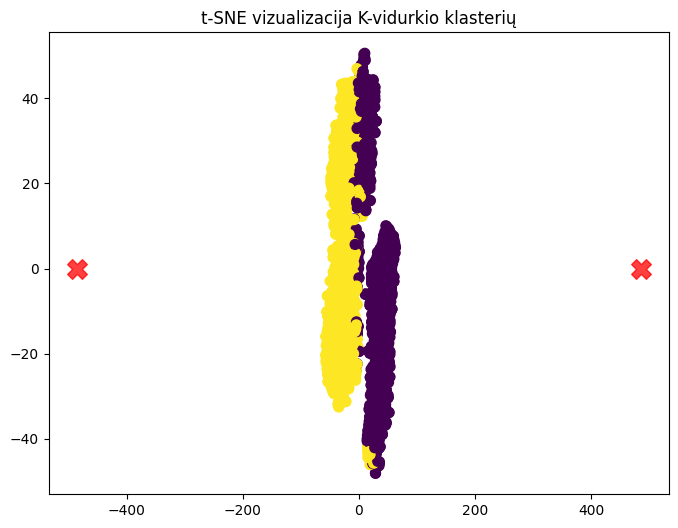

In [116]:
kmeans_with_tsne(datasetArray, 2)

Silhouette Score for n_clusters=2: 0.35


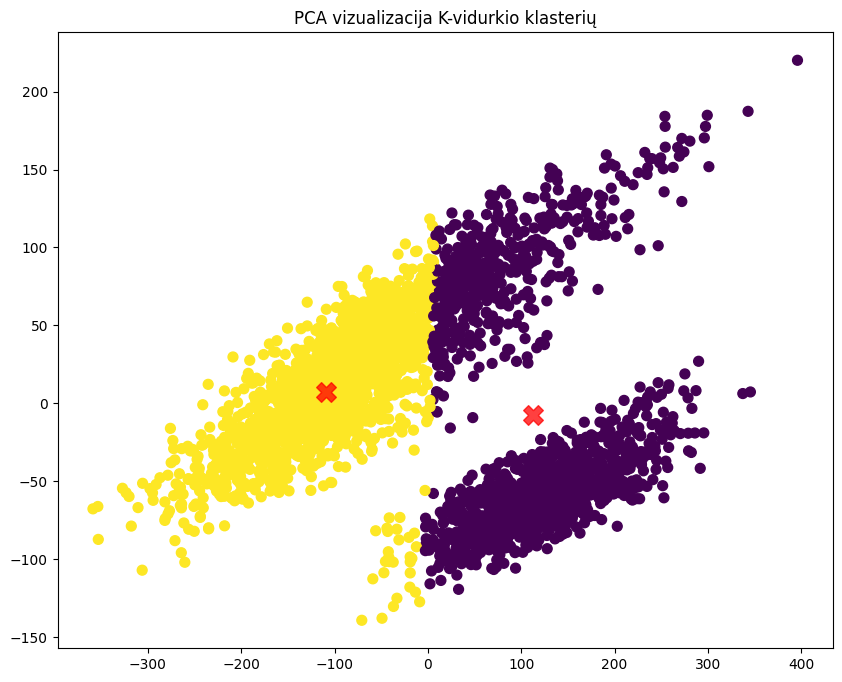

In [117]:
kmeans_with_pca(datasetArray, 2)

Silhouette Score for n_clusters=5: 0.19


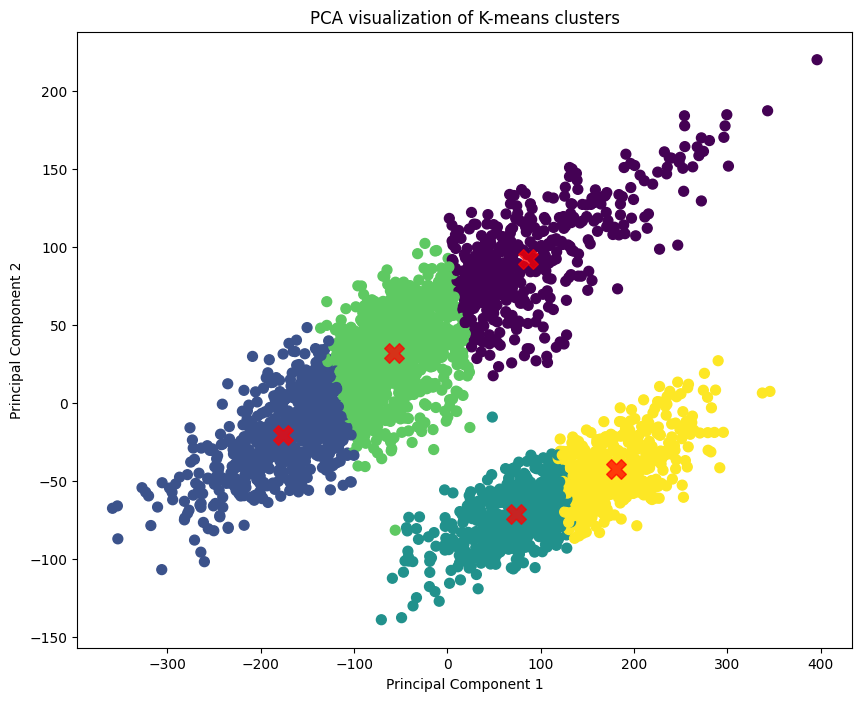

In [36]:
kmeans_with_pca(datasetArray, 5)

Silhouette Score for n_clusters=6: 0.17


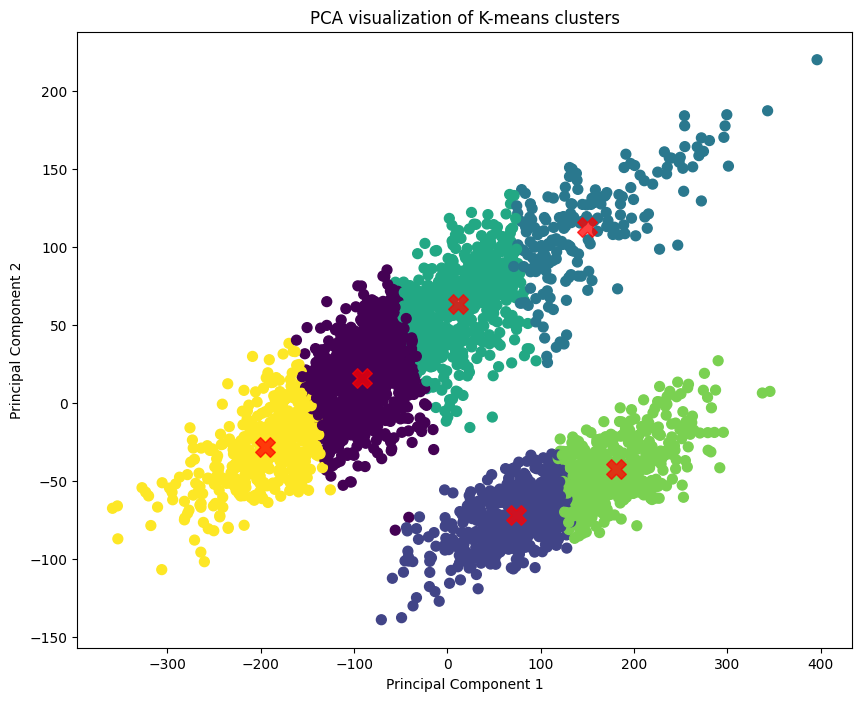

In [37]:
kmeans_with_pca(datasetArray, 6)

Silhouette Score for n_clusters=7: 0.17


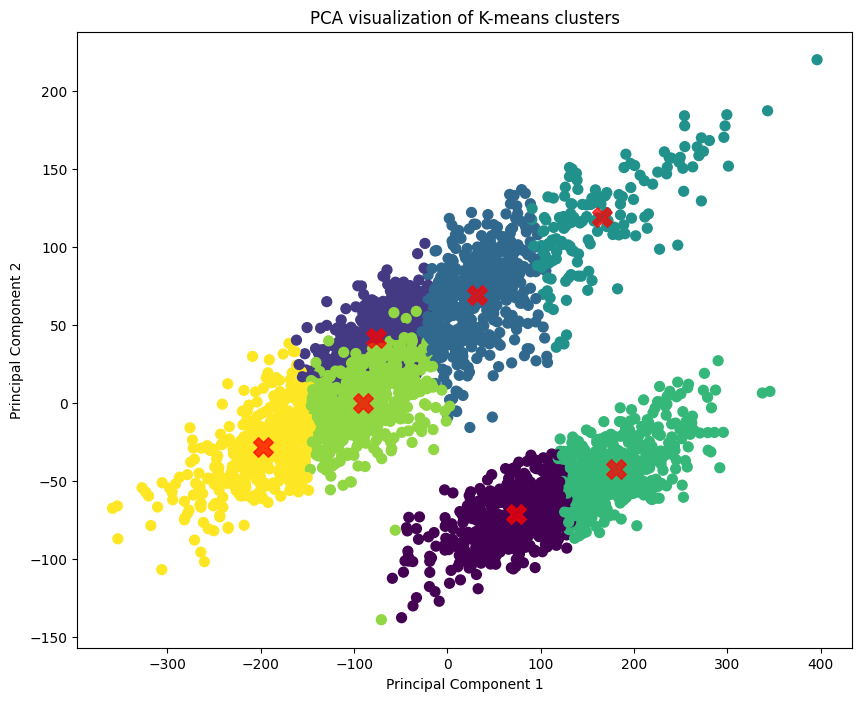

Silhouette Score for n_clusters=8: 0.14


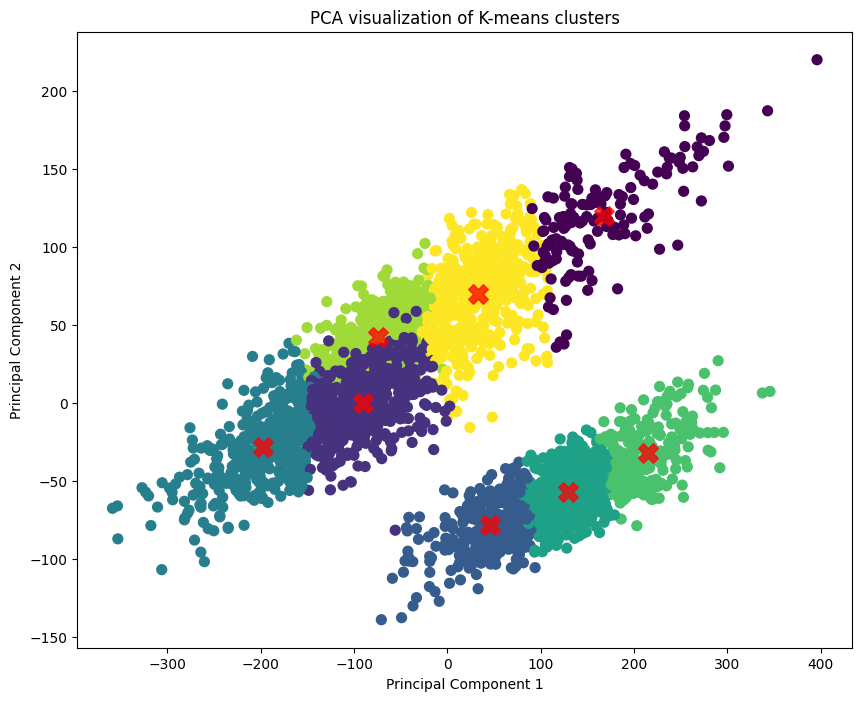

Silhouette Score for n_clusters=9: 0.13


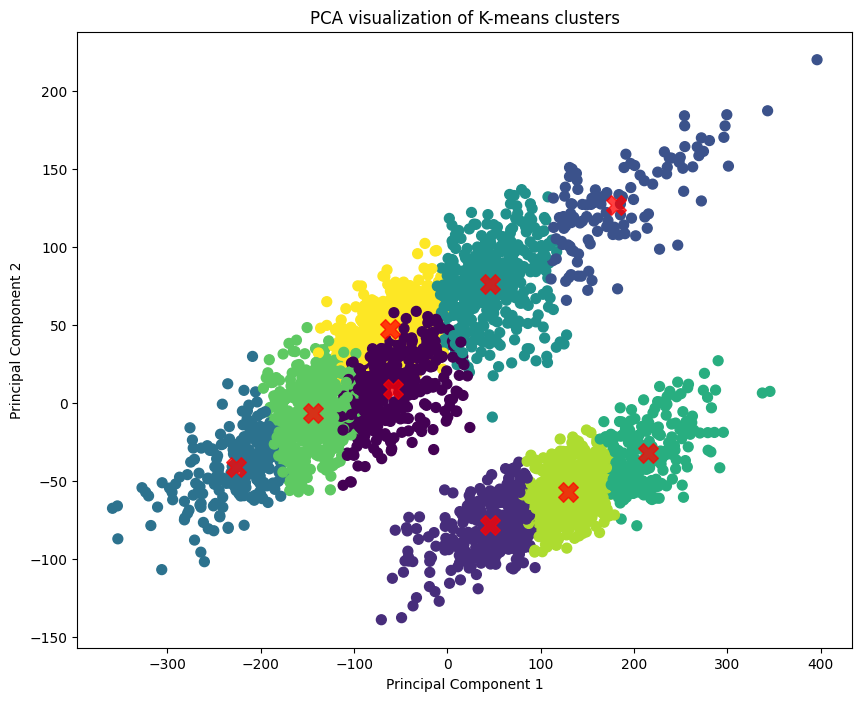

Silhouette Score for n_clusters=10: 0.12


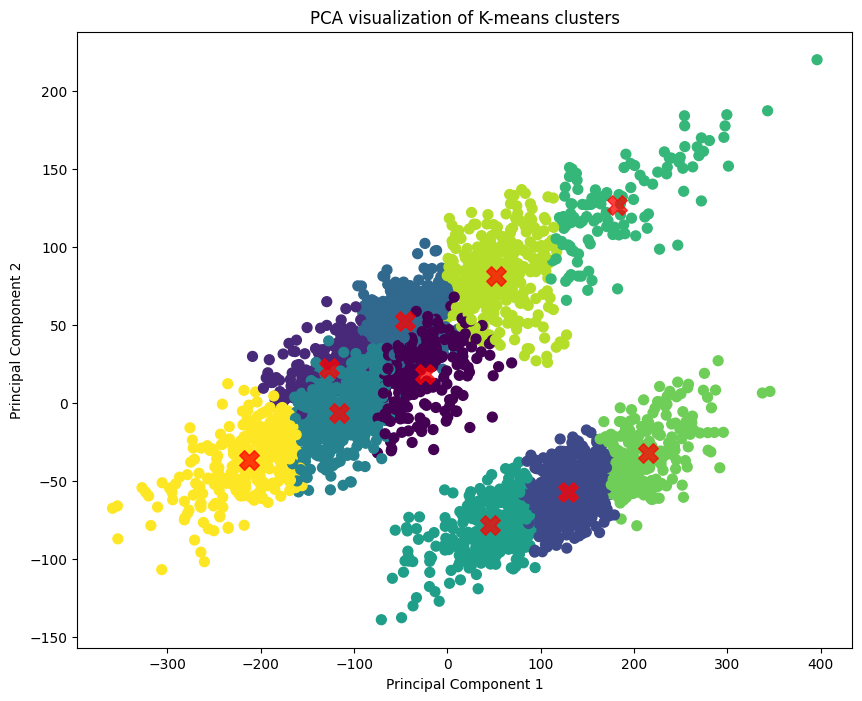

In [38]:
kmeans_with_pca(datasetArray, 7)
kmeans_with_pca(datasetArray, 8)
kmeans_with_pca(datasetArray, 9)
kmeans_with_pca(datasetArray, 10)

Silhouette Score for n_clusters=2: 0.35


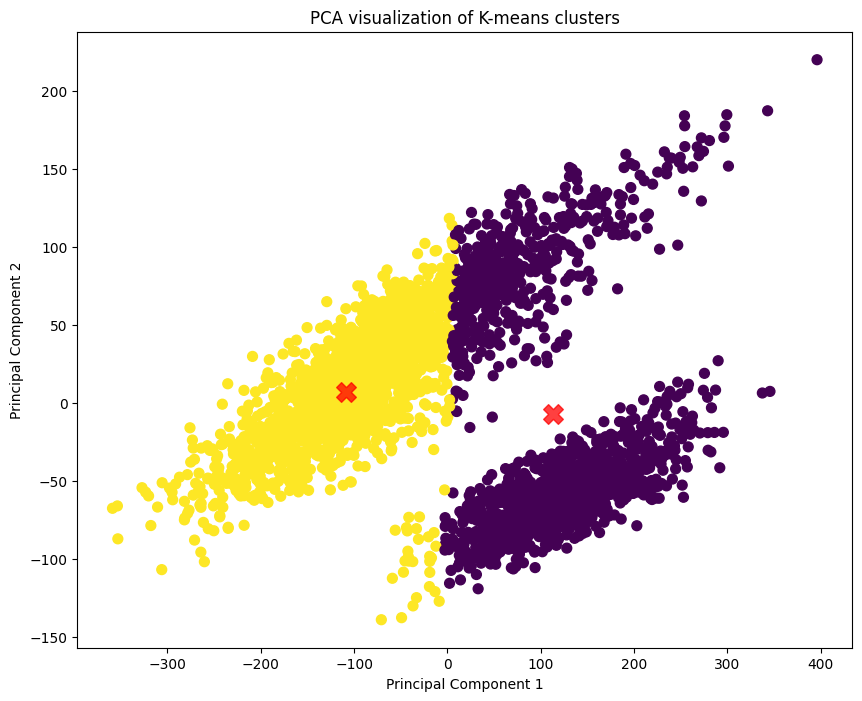

In [43]:
kmeans_with_pca(datasetArray, 2)

In [ ]:
kmeans_with_tsne(datasetArray, 3)

In [ ]:
kmeans_with_tsne(datasetArray, 4)

In [ ]:
kmeans_with_tsne(datasetArray, 5)

In [ ]:
kmeans_with_tsne(datasetArray, 6)

In [ ]:
kmeans_with_tsne(datasetArray, 2)